# Author Classification Challenge

In [0]:
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from wordcloud import WordCloud
from scipy.spatial.distance import cdist
import io
import spacy
import re
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, Dropout, Convolution1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Conv1D, Input
from tensorflow.python.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Uploading Data

In [0]:
from google.colab import files
uploaded = files.upload()



Saving data.csv to data.csv


# Loading Data:

In [0]:
# load data to data frame. loads only relevant columns: text, author
df = pd.read_csv(io.BytesIO(uploaded['data.csv']), usecols=['text', 'author'])

# Data Visualization:

## 1. Data Peek





In [0]:
# prints first 5 elements of data
df.head()

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL


## 2. Data Info





In [0]:
# data info.
print('df info.:')
df.info()

df info.:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 2 columns):
text      19579 non-null object
author    19579 non-null object
dtypes: object(2)
memory usage: 306.0+ KB


## 3. Labels Visualization


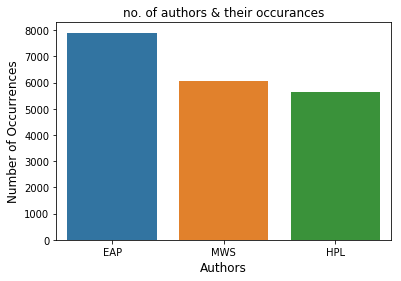

In [0]:
# plot no. of authors & occurances of them in the data
def authors_count_barplot(authors_count):
  """
  plots a bar of number of occurrences of text of every author in data 
  """
  sns.barplot(authors_count.index, authors_count.values)
  plt.title('no. of authors & their occurances')
  plt.ylabel('Number of Occurrences', fontsize=12)
  plt.xlabel('Authors', fontsize=12)
  plt.show()
  
authors_count = df['author'].value_counts()  
authors_count_barplot(authors_count)

## 4. Word Frequancy Visualization





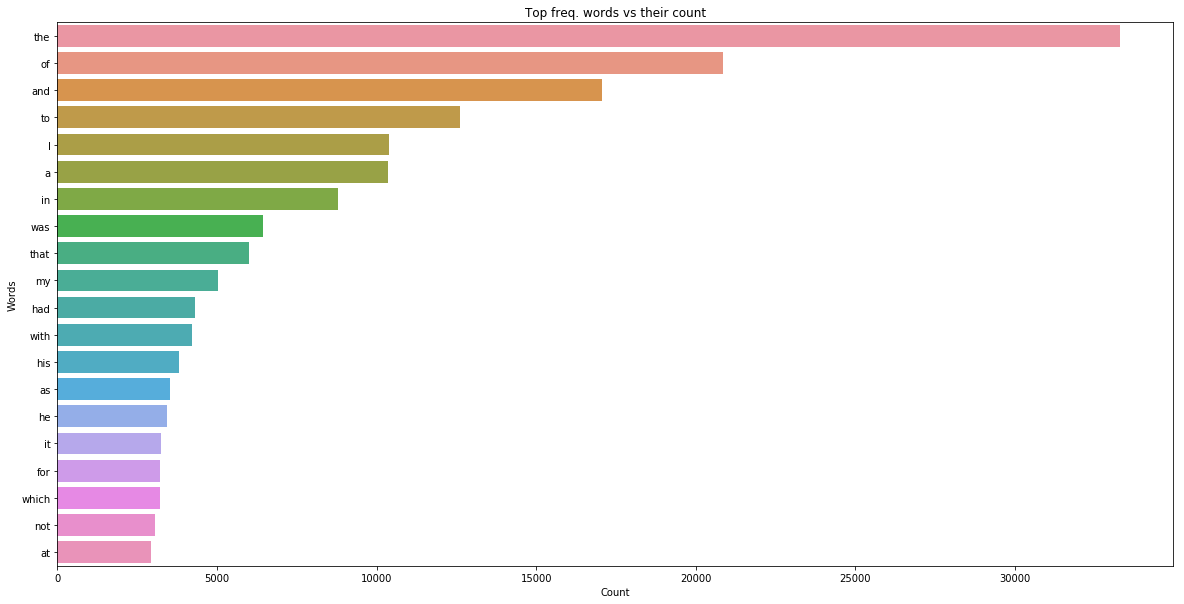

In [0]:
# Word Frequancy Visualization
def word_freq_bar(all_words, num_of_words):
  """
  plots n most frequant words in text as a bar 
  """
  plt.figure(figsize=(20, 10))
  sns.barplot(all_words.values[0:num_of_words], all_words.index[0:num_of_words])
  plt.title('Top freq. words vs their count')
  plt.xlabel('Count')
  plt.ylabel('Words')

all_words = df['text'].str.split(expand=True).unstack().value_counts()  
word_freq_bar(all_words, 20)

## 5. Word Cloud





Number of words in all_text: 2937973


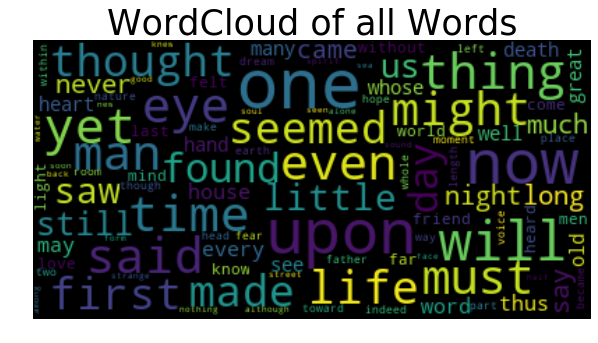

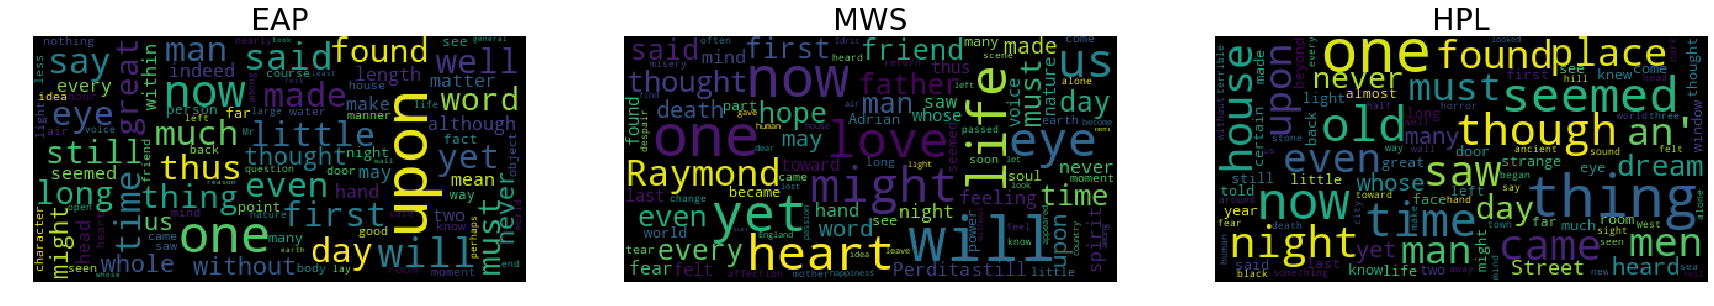

In [0]:
# word cloud :)
text = ' '.join([text for text in df['text']])
print('Number of words in all_text:', len(text))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud of all Words', size=35)
plt.show()


author_list = ['EAP', 'MWS', 'HPL']

def word_cloud_subplot(labels_list, columns, rows, sizew, sizeh):
  fig=plt.figure(figsize=(sizew, sizeh))
  for i in range(len(author_list)):
      l = df[df['author'] == author_list[i]]
      l_text = ' '.join(text for text in l['text'])
      wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(l_text)
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(wordcloud)
      plt.title(author_list[i], size=30)
      plt.axis('off')

  plt.show()

word_cloud_subplot(author_list, 3, 1, 30, 50)  
  

# Data Preprocessing: clean, shape & prepare the data to fit classification model




1.  Here we cleanup the text column for the given data from any unnecessary objects: stopwords, punctuations, lemmatize & punctuation




In [1]:
nlp = spacy.load('en_core_web_sm')
all_text = df['text']
  
punctuations = string.punctuation
stopwords = stopwords.words('english')

def clean_text(docs):
  """
  This function cleans the text from stopwords, punctuations, lemmatize
  & punctuation, using spaCy. 
  returns: pd.Series of 'text' column
  """
  texts = []
  for doc in tqdm(docs, desc='Cleaning text:'):
    doc = nlp(doc, disable=['parser', 'ner']) # spaCy pipeline
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
  return pd.Series(texts)

cleaned_text = clean_text(all_text)

NameError: ignored



##    word frequancy visualization after cleanup:






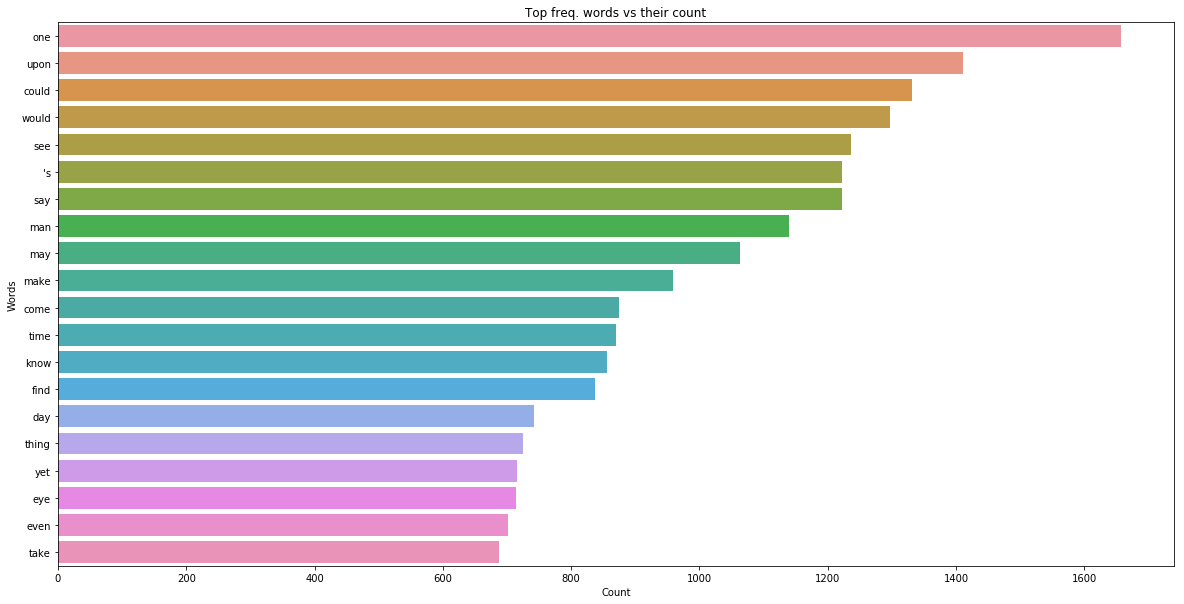

In [0]:
all_words_after_cleanup = cleaned_text.str.split(expand=True).unstack().value_counts()  
word_freq_bar(all_words_after_cleanup, 20)

## One-Hot Encodding: let turn the labels of authors to One-Hot vectors

In [0]:
y_ohe = label_binarize(df['author'], classes=['EAP', 'HPL', 'MWS'])
print('y_ohe shape: {}'.format(y_ohe.shape))
print('y_ohe samples:')
print(y_ohe[:4])

y_ohe shape: (19579, 3)
y_ohe samples:
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]]


# Tokenizer


In [0]:
num_words = len(all_words_after_cleanup)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(cleaned_text)
# see the word token dictionary 
print("word token dictionary: " + str(tokenizer.word_index) +'\n')
# tokenize all texts to lists of these tokens
cleaned_text_tokens = tokenizer.texts_to_sequences(cleaned_text)

# exemples:
print("x_train_text exmple: " + str(cleaned_text[1]) + '\n')
print("array x_train_tokens exmple: " + str(np.array(cleaned_text_tokens[1])))

word token dictionary: {'one': 1, 'upon': 2, 'could': 3, 'would': 4, 'see': 5, "'s": 6, 'say': 7, 'man': 8, 'may': 9, 'make': 10, 'come': 11, 'time': 12, 'know': 13, 'find': 14, 'day': 15, 'thing': 16, 'yet': 17, 'eye': 18, 'even': 19, 'take': 20, 'great': 21, 'seem': 22, 'old': 23, 'go': 24, 'like': 25, 'first': 26, 'life': 27, 'must': 28, 'night': 29, 'give': 30, 'look': 31, 'never': 32, 'long': 33, 'think': 34, 'feel': 35, 'every': 36, 'little': 37, 'still': 38, 'become': 39, 'place': 40, 'hear': 41, 'many': 42, 'good': 43, 'well': 44, 'hand': 45, 'house': 46, 'much': 47, 'love': 48, 'year': 49, 'tell': 50, 'two': 51, 'word': 52, 'leave': 53, 'light': 54, 'death': 55, 'heart': 56, 'speak': 57, 'ever': 58, 'mind': 59, 'thus': 60, 'whose': 61, 'friend': 62, 'without': 63, 'far': 64, 'form': 65, 'shall': 66, 'fear': 67, 'however': 68, 'last': 69, 'head': 70, 'room': 71, 'fall': 72, 'door': 73, 'pass': 74, 'earth': 75, 'hour': 76, 'dream': 77, 'world': 78, 'appear': 79, 'open': 80, 'way

### Tokenizer invert to words - helper func

In [0]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def tokens_to_text(tokens):
    """
    this function will map tokens back to their text representation
    """
    words = [inverse_map[token] for token in tokens if token != 0]   
    text = " ".join(words)
    return text
  
# exemple:
tokens_to_text(np.array(cleaned_text_tokens[1]))  

'never occur fumbling may mere mistake'

# Padding and Truncating Data

In [0]:
pad = 'pre'

num_tokens = [len(tokens) for tokens in cleaned_text_tokens]
num_tokens = np.array(num_tokens)

np.mean(num_tokens)
print(np.max(num_tokens))
np.max(num_tokens)

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

np.sum(num_tokens < max_tokens) / len(num_tokens)
print("precente of tokens under max: " + str(100 * np.sum(num_tokens < max_tokens) / len(num_tokens)) + "%")

# padding data
cleaned_text_tokens_pad = pad_sequences(cleaned_text_tokens, maxlen=max_tokens,padding=pad, truncating=pad)
print("cleaned_text_tokens shape: " + str(cleaned_text_tokens_pad.shape))


NameError: ignored

# Spliting the data to training & test sets

In [0]:
x_train_pad, x_test_pad, y_train_pad, y_test_pad = train_test_split(cleaned_text_tokens_pad, y_ohe, test_size=0.2, random_state=1)
print("Train-set shape: ", x_train_pad.shape)
print("Train-set-label shape: ", y_train_pad.shape)
print("Test-set shape: ", x_test_pad.shape)
print("Test-set-label shape: ", y_test_pad.shape)

Train-set shape:  (15663, 32)
Train-set-label shape:  (15663, 3)
Test-set shape:  (3916, 32)
Test-set-label shape:  (3916, 3)


# Building The Model

In [0]:
model = Sequential()

model.add(Embedding(num_words,20,input_length=max_tokens))
model.add(GlobalAveragePooling1D())
model.add(Dense(3, activation='softmax'))

# callbacks
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 32, 20)            386720    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 386,783
Trainable params: 386,783
Non-trainable params: 0
_________________________________________________________________


# Training session

In [0]:
estimator= model.fit(x_train_pad, y_train_pad, validation_split=0.2, epochs=12, batch_size=16)
result = model.evaluate(x_test_pad, y_test_pad)
print("Accuracy: {0:.2%}".format(result[1]))

Train on 12530 samples, validate on 3133 samples
Epoch 1/12
12530/12530 [==============================] - 3s 230us/sample - loss: 1.0387 - acc: 0.4543 - val_loss: 0.9414 - val_acc: 0.6135
Epoch 2/12
12530/12530 [==============================] - 3s 214us/sample - loss: 0.7872 - acc: 0.7390 - val_loss: 0.6914 - val_acc: 0.7520
Epoch 3/12
12530/12530 [==============================] - 3s 217us/sample - loss: 0.5520 - acc: 0.8364 - val_loss: 0.5587 - val_acc: 0.8091
Epoch 4/12
12530/12530 [==============================] - 3s 216us/sample - loss: 0.4194 - acc: 0.8758 - val_loss: 0.5035 - val_acc: 0.8047
Epoch 5/12
12530/12530 [==============================] - 3s 213us/sample - loss: 0.3368 - acc: 0.8991 - val_loss: 0.4594 - val_acc: 0.8209
Epoch 6/12
12530/12530 [==============================] - 3s 214us/sample - loss: 0.2770 - acc: 0.9169 - val_loss: 0.4410 - val_acc: 0.8222
Epoch 7/12
12530/12530 [==============================] - 3s 215us/sample - loss: 0.2314 - acc: 0.9316 - val_lo

# Evaluate results




## 1.   Model Accuracy Plot


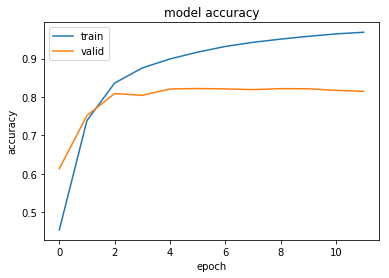

In [0]:
# Plot model accuracy over epochs
def plot_model_training(estim1, estim2, title, y):
  plt.plot(estimator.history[estim1])
  plt.plot(estimator.history[estim2])
  plt.title(title)
  plt.ylabel(y)
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  
plot_model_training('acc', 'val_acc', 'model accuracy', 'accuracy')  

## 2.   Model Loss Plot



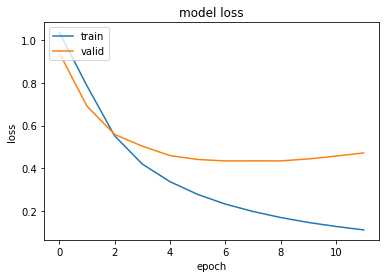

In [0]:
plot_model_training('loss', 'val_loss', 'model loss', 'loss')



## 3.   Accuracy score with Test-Set



In [0]:
y_pred_conf = model.predict(x_test_pad) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test_pad,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 81.9%




## 4.   Confusion Matrix




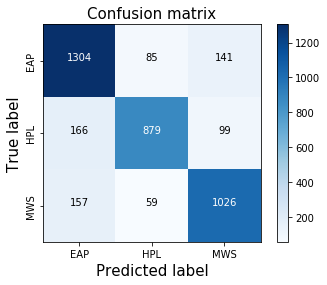

In [0]:
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['EAP', 'HPL', 'MWS']
    plt.xticks([0,1,2], classes, fontsize=10)
    plt.yticks([0,1,2], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)

plot_confusion_matrix(confusion_matrix(y_label,y_pred))